In [1]:
# resnet18_training.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Paths
DATASET_DIR = "../data/processed"
train_dir = os.path.join(DATASET_DIR, "train")
val_dir = os.path.join(DATASET_DIR, "val")
test_dir = os.path.join(DATASET_DIR, "test")

In [4]:
# Transforms for ResNet18
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
# Load datasets
datasets_dict = {
    'train': datasets.ImageFolder(train_dir, transform=transform),
    'val': datasets.ImageFolder(val_dir, transform=transform),
    'test': datasets.ImageFolder(test_dir, transform=transform)
}

In [6]:
# DataLoaders
dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size=32, shuffle=(x == 'train'), num_workers=4, prefetch_factor=4)
    for x in ['train', 'val', 'test']
}

class_names = datasets_dict['train'].classes
num_classes = len(class_names)

In [7]:
# === NEW: Compute class weights ===
train_labels = [label for _, label in datasets_dict['train']]
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [8]:
# Load pretrained ResNet18 and modify final layer
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
# todo take this out later
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all layers
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [9]:
# Use weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# Get trainable parameters only
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

In [10]:
# TensorBoard writer
writer = SummaryWriter(log_dir="runs/resnet18_experiment_2")

In [11]:
# Training loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_val_loss = float('inf')
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for i, (inputs, labels) in enumerate(tepoch):
                    # Optional: show batch progress every 10 batches
                    # if i % 10 == 0:  # 🔍 Debug: monitor training progress
                    #     print(f"[{phase.upper()}] Epoch {epoch+1} - Batch {i+1}/{len(dataloaders[phase])}")  # REMOVE LATER

                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets_dict[phase])
            epoch_acc = running_corrects.double() / len(datasets_dict[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
            writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)

            if phase == 'train':
                train_loss_hist.append(epoch_loss)
                train_acc_hist.append(epoch_acc.item())
            else:
                val_loss_hist.append(epoch_loss)
                val_acc_hist.append(epoch_acc.item())
                scheduler.step(epoch_loss)

                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    torch.save(model.state_dict(), "../model/dermai_model.pth")

    print("\nTraining complete. Best validation loss: {:.4f}".format(best_val_loss))
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist


In [12]:
# Train
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)


Epoch 1/10
--------------------


100%|██████████| 489/489 [08:32<00:00,  1.05s/batch]


Train Loss: 1.6224 Acc: 0.4527


100%|██████████| 105/105 [01:25<00:00,  1.22batch/s]


Val Loss: 1.3176 Acc: 0.5397

Epoch 2/10
--------------------


100%|██████████| 489/489 [08:18<00:00,  1.02s/batch]


Train Loss: 1.0389 Acc: 0.5770


100%|██████████| 105/105 [01:27<00:00,  1.21batch/s]


Val Loss: 1.1070 Acc: 0.6179

Epoch 3/10
--------------------


100%|██████████| 489/489 [08:18<00:00,  1.02s/batch]


Train Loss: 0.9015 Acc: 0.6309


100%|██████████| 105/105 [01:24<00:00,  1.24batch/s]


Val Loss: 1.1872 Acc: 0.6128

Epoch 4/10
--------------------


100%|██████████| 489/489 [08:19<00:00,  1.02s/batch]


Train Loss: 0.7481 Acc: 0.6780


100%|██████████| 105/105 [01:26<00:00,  1.22batch/s]


Val Loss: 1.0971 Acc: 0.6197

Epoch 5/10
--------------------


100%|██████████| 489/489 [08:30<00:00,  1.04s/batch]


Train Loss: 0.6607 Acc: 0.7074


100%|██████████| 105/105 [01:26<00:00,  1.22batch/s]


Val Loss: 0.9667 Acc: 0.6758

Epoch 6/10
--------------------


100%|██████████| 489/489 [08:18<00:00,  1.02s/batch]


Train Loss: 0.5895 Acc: 0.7361


100%|██████████| 105/105 [01:25<00:00,  1.23batch/s]


Val Loss: 0.8875 Acc: 0.7111

Epoch 7/10
--------------------


100%|██████████| 489/489 [08:24<00:00,  1.03s/batch]


Train Loss: 0.5220 Acc: 0.7544


100%|██████████| 105/105 [01:26<00:00,  1.22batch/s]


Val Loss: 0.8879 Acc: 0.7078

Epoch 8/10
--------------------


100%|██████████| 489/489 [08:22<00:00,  1.03s/batch]


Train Loss: 0.4509 Acc: 0.7838


100%|██████████| 105/105 [01:26<00:00,  1.21batch/s]


Val Loss: 0.9289 Acc: 0.7126

Epoch 9/10
--------------------


100%|██████████| 489/489 [08:16<00:00,  1.02s/batch]


Train Loss: 0.4255 Acc: 0.7934


100%|██████████| 105/105 [01:24<00:00,  1.25batch/s]


Val Loss: 0.7892 Acc: 0.7468

Epoch 10/10
--------------------


100%|██████████| 489/489 [08:13<00:00,  1.01s/batch]


Train Loss: 0.3600 Acc: 0.8243


100%|██████████| 105/105 [01:24<00:00,  1.24batch/s]

Val Loss: 1.1481 Acc: 0.6800

Training complete. Best validation loss: 0.7892


In [13]:
# Save complete model for inference
complete_model_path = "../model/dermai_model.pt"
torch.save(model, complete_model_path)
print(f"\nFinal model saved to {complete_model_path}")



Final model saved to ../model/dermai_model.pt


In [14]:
# Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


In [15]:
evaluate_model(model, dataloaders["test"])


Test Accuracy: 69.05%


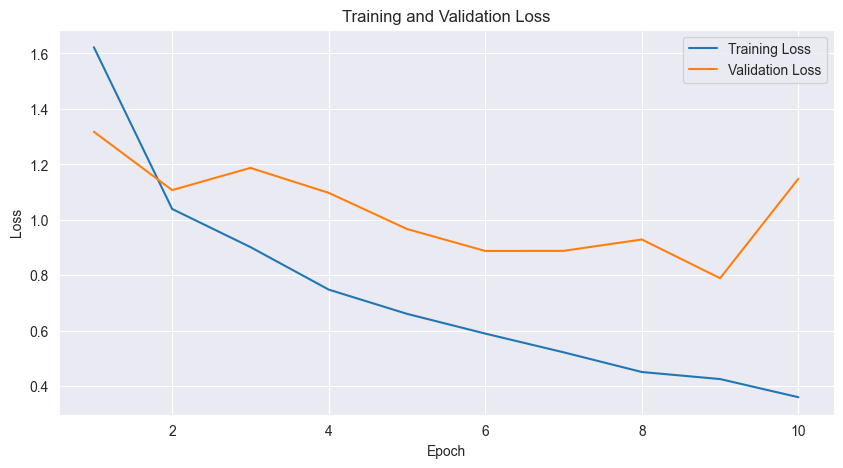

In [16]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist,label="Training Loss")
plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("loss_curve.png")
plt.show()


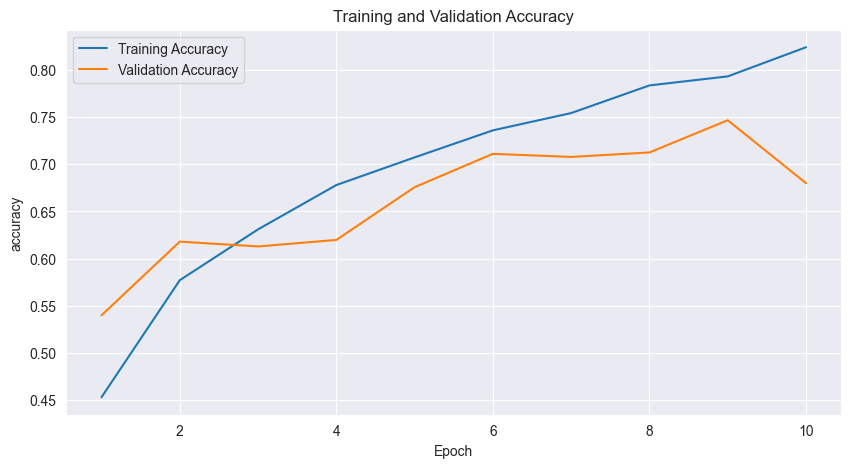

In [17]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_hist) + 1), train_acc_hist,label="Training Accuracy")
plt.plot(range(1, len(val_acc_hist) + 1), val_acc_hist,label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.savefig("accuracy_curve.png")
plt.show()

writer.close()